In [2]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt

from model import AutoEncoder
from generate import sin_cos, arma, wind
from train import train
from functional import *
from utils import *

from model2 import VAutoEncoder

import seaborn as sns
import scipy
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import calinski_harabasz_score
import pandas as pd

torch.manual_seed(4444)
np.random.seed(4444)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Create Dataset

In [279]:
n_train = 1024
n_valid = 128
n_test = 128
n = n_train+n_valid+n_test

length = 64 # each observation is a vector of size (1,length)

## Generate documents

In [280]:
X = arma(n, length)
#X = wind(num_elems=length)
#X = sin_cos(n, length)

X = torch.from_numpy(X)

X_train, X_valid, X_test = X[:n_train], X[n_train:n_train+n_valid], X[n_train+n_valid:]

In [164]:
X.shape

torch.Size([900, 1, 64])

# Model

In [283]:
M = 4 # number of filters per conv
Lf = 3 # size of the filters
bottleneck_nn = 32
model = VAutoEncoder(length=length, Lf=Lf, M=M, bottleneck_nn=bottleneck_nn)

## Train

In [284]:
train_losses, valid_losses = train(model, X_train, X_valid, iters=3000, early_stopping_rounds=30)

EPOCH 10 train loss: 1.2755233645439148, valid loss: 1.2118489146232605
epochs without improvement: 0

EPOCH 20 train loss: 0.7683946043252945, valid loss: 0.7524694800376892
epochs without improvement: 0

EPOCH 30 train loss: 0.6073153801262379, valid loss: 0.601452112197876
epochs without improvement: 0

EPOCH 40 train loss: 0.5543027091771364, valid loss: 0.570073813199997
epochs without improvement: 1

EPOCH 50 train loss: 0.533295152708888, valid loss: 0.5426604151725769
epochs without improvement: 2

EPOCH 60 train loss: 0.5218406170606613, valid loss: 0.5351419001817703
epochs without improvement: 2

EPOCH 70 train loss: 0.5133926030248404, valid loss: 0.5272112339735031
epochs without improvement: 2

EPOCH 80 train loss: 0.5091238208115101, valid loss: 0.5241738855838776
epochs without improvement: 1

EPOCH 90 train loss: 0.5063764089718461, valid loss: 0.5223594754934311
epochs without improvement: 4

EPOCH 100 train loss: 0.5031621493399143, valid loss: 0.5128123909235001
epo

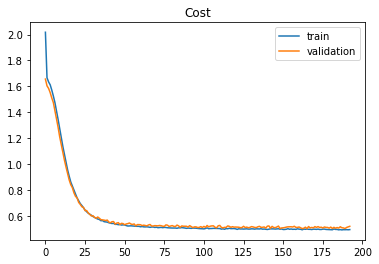

In [285]:
plt.title("Cost")
plt.plot(train_losses, label="train")
plt.plot(valid_losses, label="validation")
plt.legend()

## Load/Save model

In [ ]:
#torch.save(model.state_dict(), "../saved_weights/wind64_model")
#model.load_state_dict(torch.load("../saved_weights/wind6_model"))

# Testing

## Average and std correlation

test loss: 8.358903884887695
correlation avg and std: 0.8510559752747251 0.049973697001384154

spearman: 0.8191849816849817
spearman: 0.8066849816849816
spearman: 0.8844780219780218
spearman: 0.8212454212454212


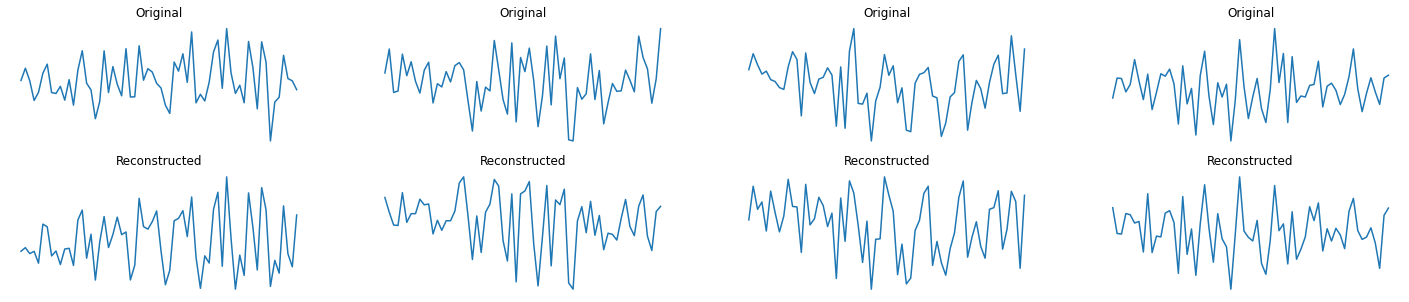

In [286]:
pred1 = model(X_test)

print(f"test loss: {my_mse(X_test,model(X_test)) + my_l2(model)}")

pred1 = pred1.detach().numpy()

# mean cors
cors = [scipy.stats.spearmanr(pred1[i,0], X_test[i,0]).correlation for i in range(n_test)]
print("correlation avg and std:", np.mean(cors), np.std(cors))
print()

# plot
n_plots = 4
start = n_plots*0

fig, axs = plt.subplots(nrows=2, ncols=n_plots, figsize=(25,5))
for i in range(n_plots):
    
    axs[0,i].axis("off")
    axs[0,i].set_title("Original")
    axs[0,i].plot(X_test[start+i,0])

    axs[1,i].axis("off")
    axs[1,i].set_title("Reconstructed")
    axs[1,i].plot(pred1[start+i,0])
    print("spearman:", scipy.stats.spearmanr(pred1[start+i,0], X_test[start+i,0]).correlation)

# Latent space

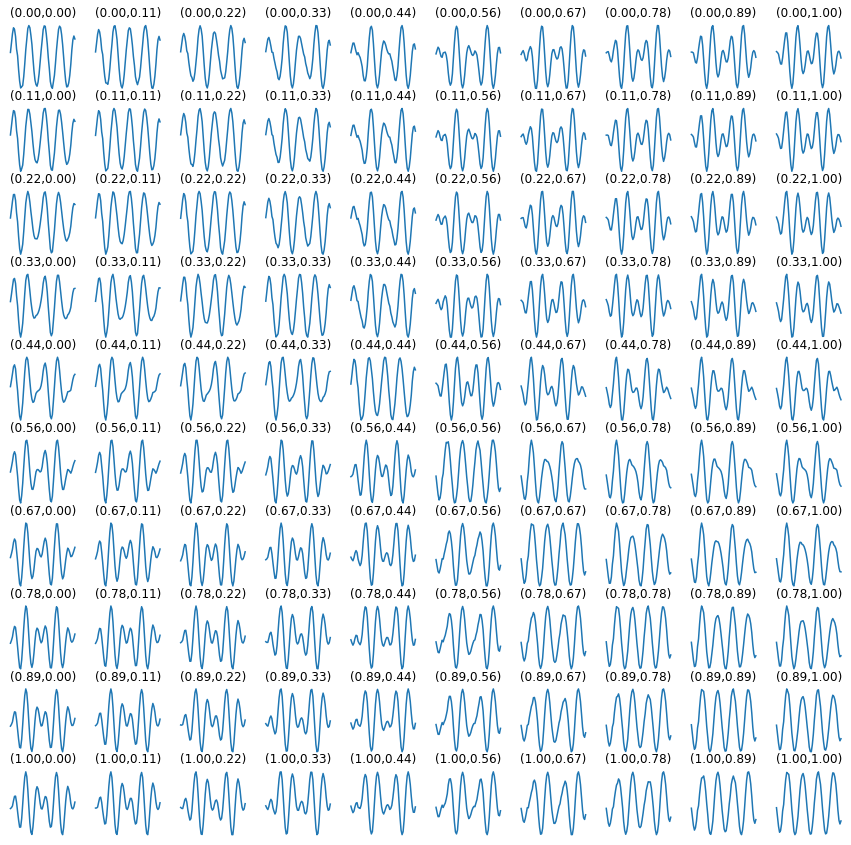

In [247]:
if bottleneck_nn == 2:
    latent_space(model, n=10)

# Choose bootleneck

In [ ]:
vals = choose_bottleneck(X_test, X_train, X_valid, length, M, Lf)

In [ ]:
plt.plot([np.mean(x) for x in vals], "-o", [1]*len(vals))

# Checking important filters

<AxesSubplot:>

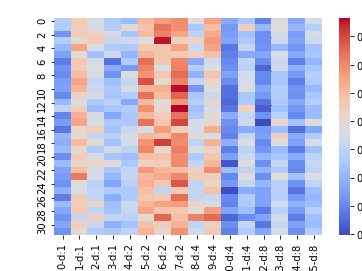

In [287]:
num_filter = 4*M
w_per_filter = length-Lf+1 # weights per filter
w = np.array([[torch.mean(torch.abs(model.full1.weight[j,i*w_per_filter:(i+1)*w_per_filter])).item() for i in range(num_filter)] for j in range(bottleneck_nn)])

x_axis_labels = [f"{i}-d:{2**(i//M)}" for i in range(w.shape[1])] # number of filter - d:dilatation
sns.heatmap(w, cmap="coolwarm", xticklabels=x_axis_labels) # y-axis => neuron of the bottleneck, x-axis => each position is one filter ordered by dilatation

In [ ]:
clustering = KMeans(n_clusters=2)
clustering.fit(w.T) # tranposed -> cluster por columnas
clustering.labels_

# Clustering using bootleneck

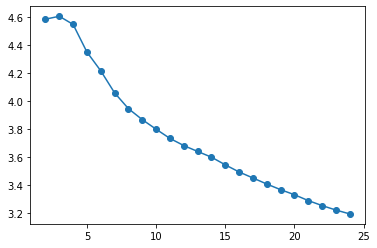

In [289]:
bns = model.forward(X_test, get_bottleneck=True).detach().numpy()
chs = []
for i in range(2,25):
    clustering = AgglomerativeClustering(n_clusters=i)
    clustering.fit(bns) 
    clus = clustering.labels_
    ch = calinski_harabasz_score(bns,clus)
    chs.append(ch)
plt.plot(range(2,len(chs)+2), chs, "o-")

In [299]:
clustering = AgglomerativeClustering(n_clusters=2)
clustering.fit(bns)
clus = clustering.labels_

In [290]:
if bns.shape[1] <= 10: # more than 10 plots is slow
    sns.pairplot(pd.DataFrame(bns))

KeyboardInterrupt: 

<AxesSubplot:>

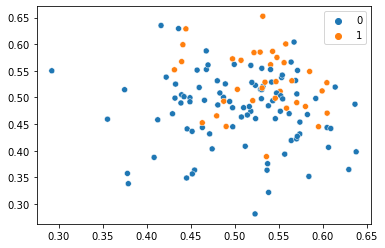

In [300]:
d1 = 0
d2 = 2
sns.scatterplot(bns[:,d1], bns[:,d2], clus)